In [1]:
import os
import sys
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

PROJECT_PATH = os.path.abspath(os.path.join("..", ".."))
PIPELINE_PATH = os.path.join(PROJECT_PATH, "pipeline")
DATA_DIRECTORY = os.path.join(PROJECT_PATH, "data")

unflagged_data = False

if PIPELINE_PATH not in sys.path:
    sys.path.append(PIPELINE_PATH)

from utils.config_files import load_json_config
from utils.import_data import import_acropolis_site_data
from config.sites_deloyment_times import deployment_times

from utils.paths import DESPIKED_DATA_DIRECTORY, CONFIG_DIRECTORY

assert (os.path.exists(DESPIKED_DATA_DIRECTORY))

assert(os.path.exists(DESPIKED_DATA_DIRECTORY))

# load files
# load files
config = load_json_config("config.json")

path = os.path.join(CONFIG_DIRECTORY, "sites.csv")
sites_meta = pl.read_csv(path, separator=";").with_columns(
    pl.exclude(pl.Utf8).cast(str))

In [3]:
df_systems = []

for site in config["icos_cities_portal"]["site_names"]:
    df_systems.append(import_acropolis_site_data(target_directory=DESPIKED_DATA_DIRECTORY,
                                        deployment_times=deployment_times,
                                        site_name=site) \
                                    .filter(pl.col("Flag") == "U") \
                                    .with_columns(site_name = pl.lit(site)) \
                                    .select(["datetime", "system_id", "gmp343_corrected", "site_name"]))
    
    
df = pl.concat(df_systems, how="vertical")

In [4]:
df_daily = df.sort("datetime").group_by_dynamic(index_column="datetime", every="1d").agg(
    pl.col("gmp343_corrected").mean().alias("co2_mean"),
    pl.col("gmp343_corrected").std().alias("co2_std"),
    )

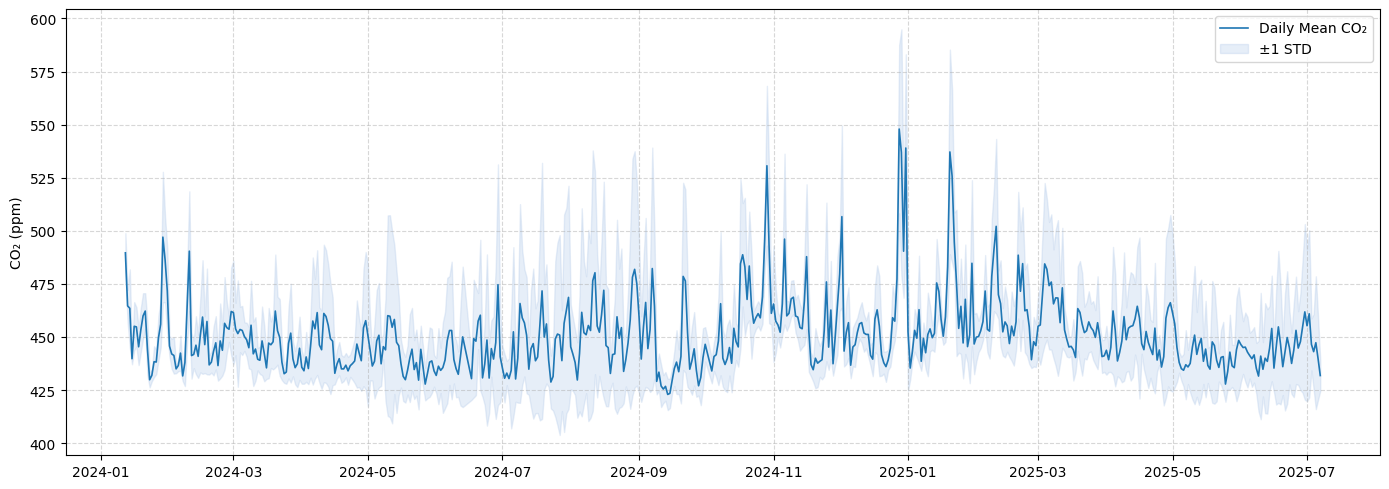

In [5]:
dates = df_daily["datetime"].to_list()
mean = df_daily["co2_mean"].to_numpy()
std = df_daily["co2_std"].to_numpy()

plt.figure(figsize=(14, 5))
plt.plot(dates, mean, label="Daily Mean CO₂", color="#1f77b4", linewidth=1.2)
plt.fill_between(dates, mean - std, mean + std, color="#aec7e8", alpha=0.3, label="±1 STD")

plt.ylabel("CO₂ (ppm)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
rural = ["MAIR", "DLRR", "TAUR", "FINR", "FELR"]

df_rural = df.filter(pl.col("site_name").is_in(rural)) \
    .sort("datetime").group_by_dynamic(index_column="datetime", every="1d").agg(
    pl.col("gmp343_corrected").mean().alias("co2_mean"),
    pl.col("gmp343_corrected").std().alias("co2_std"),
    )
    
df_urban = df.filter(~pl.col("site_name").is_in(rural)) \
    .sort("datetime").group_by_dynamic(index_column="datetime", every="1d").agg(
    pl.col("gmp343_corrected").mean().alias("co2_mean"),
    pl.col("gmp343_corrected").std().alias("co2_std"),
    )

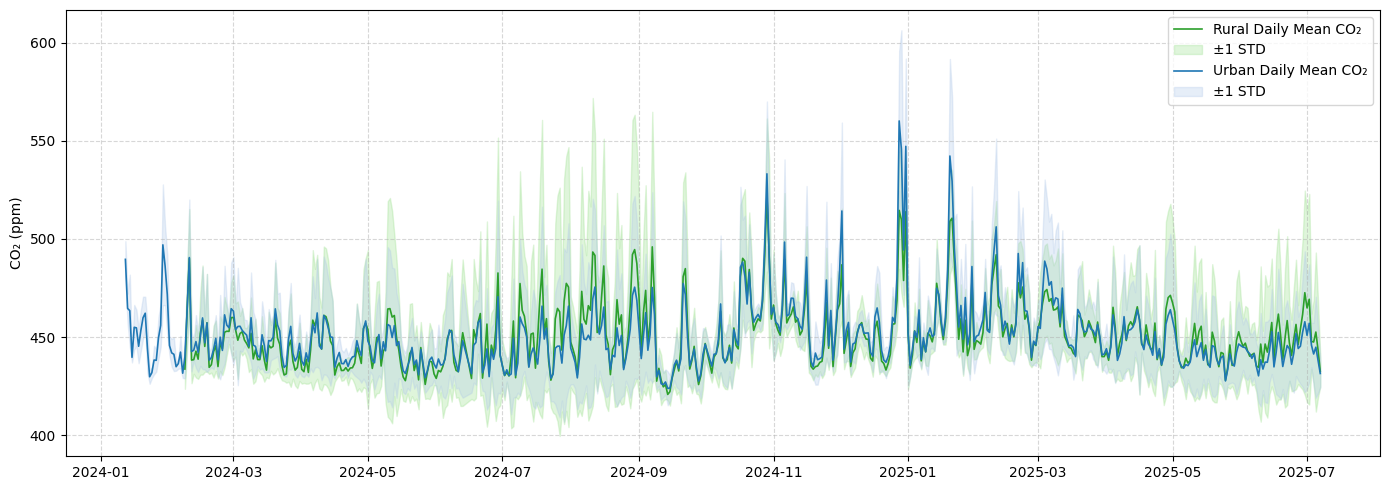

In [7]:
dates = df_rural["datetime"].to_list()
mean = df_rural["co2_mean"].to_numpy()
std = df_rural["co2_std"].to_numpy()

plt.figure(figsize=(14, 5))
plt.plot(dates, mean, label="Rural Daily Mean CO₂", color="#2ca02c", linewidth=1.2)
plt.fill_between(dates, mean - std, mean + std, color="#98df8a", alpha=0.3, label="±1 STD")

dates = df_urban["datetime"].to_list()
mean = df_urban["co2_mean"].to_numpy()
std = df_urban["co2_std"].to_numpy()

plt.plot(dates, mean, label="Urban Daily Mean CO₂", color="#1f77b4", linewidth=1.2)
plt.fill_between(dates, mean - std, mean + std, color="#aec7e8", alpha=0.3, label="±1 STD")


plt.ylabel("CO₂ (ppm)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
df_urban = df_urban.join(df_rural, on="datetime", suffix="_rural", how="inner")
df_urban = df_urban.with_columns(diff = pl.col("co2_mean") - pl.col("co2_mean_rural"))

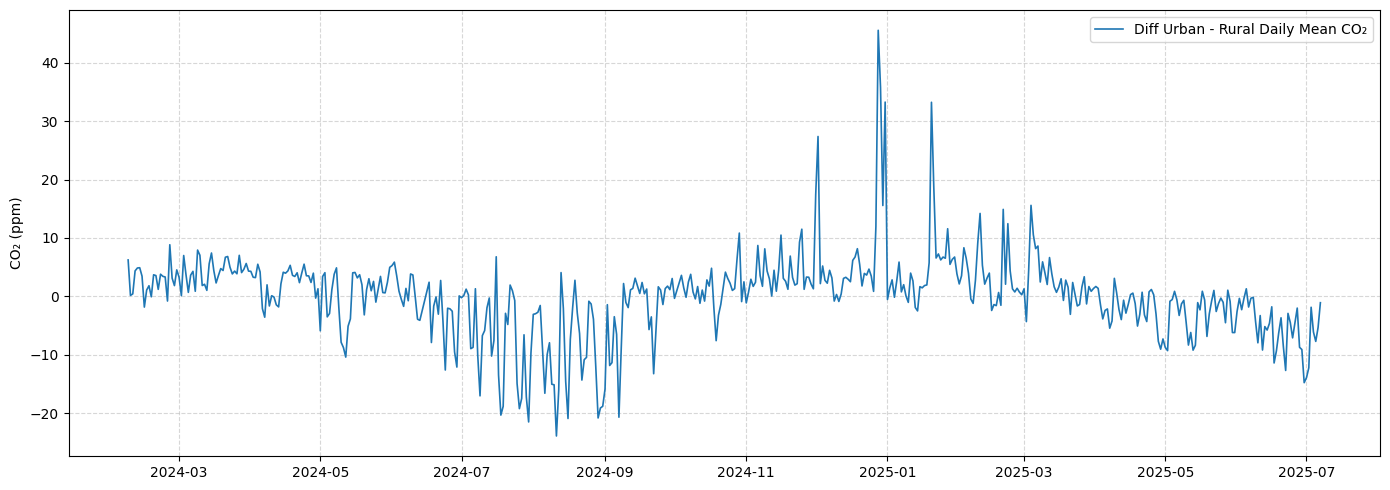

In [9]:
dates = df_urban["datetime"].to_list()
mean = df_urban["diff"].to_numpy()

plt.figure(figsize=(14, 5))
plt.plot(dates, mean, label="Diff Urban - Rural Daily Mean CO₂", color="#1f77b4", linewidth=1.2)

plt.ylabel("CO₂ (ppm)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()